# Simple FEM for an elastic plate with a hole

## Create a mesh for the plate with hole

First we need to build the geometry. The shape and mesh is generated with pygmsh, exported to a vtk file that can be visualized with ParaView, and then imported for use in scikit-fem. 

<skfem MeshTri2 object>
  Number of elements: 12021
  Number of vertices: 6163
  Number of nodes: 24346
  Named boundaries [# facets]: right [80], left [40], bottom [40], top [80]


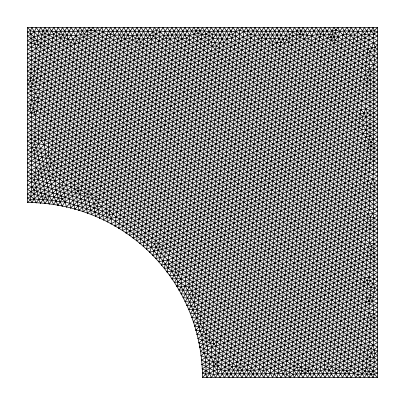

In [99]:
import copy 
import pygmsh
import numpy as np
import skfem as fem
from skfem.helpers import ddot, dot, eye, sym_grad, trace
from skfem.visuals.matplotlib import draw, plot

from global_constants import EPS0, LBD, MU, B0, L, R, RATIO

# Element size
N = 80
s = L / N

# Ellipse dimensions
Rx = 0.5
Ry = R**2 / Rx
Rz = 1.0

# Build geometry and export mesh
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = s
    rectangle = geom.add_rectangle([0.0, 0.0, 0.0], a=L, b=L)
    hole = geom.add_ellipsoid([0, 0, 0.0], [Rx, Ry, Rz])
    geom.boolean_difference(rectangle, hole)
    m = geom.generate_mesh(order=2)
    m.write("mesh.vtk")

# Convert to scikit-fem mesh
mesh = fem.MeshTet().load("mesh.vtk")

# Label boundaries
mesh = mesh.with_boundaries(
    {
        "right": lambda x: x[0] == L,
        "left": lambda x: x[0] <= 0.001,
        "bottom": lambda x: x[1] <= 0.001,
        "top": lambda x: x[1] == L,
    }
)


# Visualize the mesh
draw(mesh, figsize=(5, 5))
print(mesh)

## Create the FEM function space

In [100]:
# Define first order triangles and define a 2d variable on it (u1 and u2)
element = fem.ElementVector(fem.ElementTriP2(), 2)
# Function space
basis = fem.Basis(mesh, element)

## Material model

A single 2D ply stiffness tensor is given as 

$$
\sigma = 2\mu \nabla^s u + \lambda^* \textrm{tr}(\nabla^s u)I
$$

with 

$$
\lambda^* = \lambda  
$$

for plane strain or 

$$
\lambda^* = \frac{2\lambda\mu}{\lambda+2\mu}
$$

for plane stress.

In [101]:
def sigma(eps):
    return  2.0 * MU * eps + LBD * eye(trace(eps), 2)

## Bilinear form of the weak form

$$ \int_\Omega \sigma \left (\nabla^s u \right) : \nabla^s v dV = \int_\Omega f \cdot v dV $$

In [102]:
@fem.BilinearForm
def k(u, v, w):
    return ddot(sigma(sym_grad(u)), sym_grad(v))

@fem.LinearForm
def b(v, w):
    f = np.zeros(v.shape)
    f[0, :, :] = B0
    return dot(f, v)

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Right: 

$$ u_1 = \varepsilon_0 L\\  
   u_2 =0
$$

In [103]:
# Get all degrees of freedom and set appropiate entry to prescribed BCs.
u = basis.zeros()
u[basis.get_dofs({"right"}).nodal['u^1']] = EPS0 * L
u[basis.get_dofs({"right"}).facet['u^1']] = EPS0 * L
u[basis.get_dofs({"top"}).nodal['u^2']] = RATIO * EPS0 * L
u[basis.get_dofs({"top"}).facet['u^2']] = RATIO * EPS0 * L


cons = np.concatenate([
    basis.get_dofs({"left"}).nodal['u^1'], 
    basis.get_dofs({"left"}).facet['u^1'], 
    basis.get_dofs({"bottom"}).nodal['u^2'],
    basis.get_dofs({"bottom"}).facet['u^2'],
    basis.get_dofs({"right"}).nodal['u^1'],
    basis.get_dofs({"right"}).facet['u^1'],
    basis.get_dofs({"top"}).nodal['u^2'],
    basis.get_dofs({"top"}).facet['u^2']
    ]
)

# Get remaining degrees of freedom
I = basis.complement_dofs(cons)

## Assemble and solve

In [104]:
# Assemble matrices
K = fem.asm(k, basis)
B = fem.asm(b, basis)

# Solve the problem 
u = fem.solve(*fem.condense(K, B, x=u, I=I))

## Postprocessing

Warning: VTK requires 3D points, but 2D points given. Appending 0 third component.

Warning: VTK requires 3D vectors, but 2D vectors given. Appending 0 third component to Displacement.

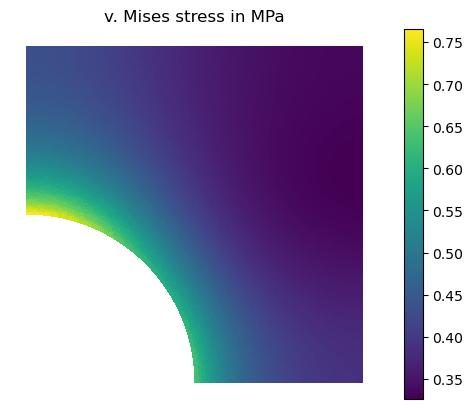

In [105]:
# Get nodal positions 
x = np.zeros_like(u)
dofs0 = list(basis.nodal_dofs[0]) + list(basis.facet_dofs[0]) 
dofs1 = list(basis.nodal_dofs[1]) + list(basis.facet_dofs[1])
x[dofs0] = mesh.doflocs[0]
x[dofs1] = mesh.doflocs[1]

# Compute stress on quadrature points
ui = basis.interpolate(u)
xi = basis.interpolate(x)
E = sym_grad(ui)
S = sigma(E)
Smises = np.sqrt(S[0,0]**2 + S[1,1]**2 - S[0,0]*S[1,1] + 3*S[0,1]**2)

# Save mesh
mesh.save(f"result_Rx={Rx}.vtk", 
            point_data={"Displacement": u.reshape((-1, 2))}, 
            cell_data={"Sxx": [np.mean(S[0,0], axis=-1)], 
                       "Sxy": [np.mean(S[0,1], axis=-1)], 
                       "Syy": [np.mean(S[1,1], axis=-1)],
                       "Exx": [np.mean(E[0,0], axis=-1)], 
                       "Exy": [np.mean(E[0,1], axis=-1)], 
                       "Eyy": [np.mean(E[1,1], axis=-1)],
                       "Smises": [np.mean(Smises, axis=-1)],
                       })

# Save results
inputs = np.stack([xi[0].ravel(), xi[1].ravel(), Rx * np.ones_like(xi[0].ravel())])
np.savetxt(f"data/inputs_Rx={Rx}.csv", inputs.T, delimiter=",", header="X,Y,R")
outputs = np.stack([S[0,0].ravel(), S[1,1].ravel(), S[0,1].ravel(), Smises.ravel(), 
                    E[0,0].ravel(), E[1,1].ravel(), E[0,1].ravel(), 
                    ui[0].ravel(), ui[1].ravel()])
np.savetxt(f"data/outputs_Rx={Rx}.csv", outputs.T, delimiter=",", header="Sxx,Syy,Sxy,Smises,Exx,Eyy,Exy,Ux,Uy")

# Compute deformed mesh
defmesh = copy.deepcopy(mesh)
defmesh.doflocs[0] += u[dofs0]
defmesh.doflocs[1] += u[dofs1]

# Plot results
p = plot(mesh, np.mean(Smises, axis=-1), colorbar=True, cmap="viridis")
p.set_title("v. Mises stress in MPa")
p.show()